In [306]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from frouros.datasets.synthetic import SEA
from frouros.metrics.prequential_error.prequential_error import PrequentialError
from frouros.metrics.prequential_error.fading_factor import PrequentialErrorFadingFactor
from frouros.supervised.ddm_based import DDM, DDMConfig
from frouros.supervised.modes import NormalMode

# Supervised - NormalMode

Example of how to use the supervised method DDM {cite:p}`gama2004learning` with the helper class NormalMode.

The data is generated in blocks (concepts) using SEA {cite:p}`street2001streaming` generator. Four different concepts of 10000 samples each are used. The first one is only used to train a model, while the other two concepts (blocks 3 and 4) are used for testing purposes following a streaming approach, in which the samples are given to the model one at a time.

In [299]:
concept_samples = 10000
generator = SEA(seed=31)
# Generate concepts 1, 3 and 4 without noise
concepts = [generator.generate_dataset(
        block=block, noise=0.0, num_samples=concept_samples,
    ) for block in [1, 3, 4]]

X, y = [], []
for concept in concepts:
    for X_sample, y_sample in concept:
        X.append(X_sample)
        y.append(y_sample)
X, y = np.array(X), np.array(y)

# Split data in reference (concept 1) and test (concepts 3 and 4)
split_idx = concept_samples
X_ref, y_ref, X_test, y_test = X[:split_idx], y[:split_idx], X[split_idx:], y[split_idx:].reshape(-1, 1)

A configuration class with the detector parameters is defined. For this particular case, it only contains warning and drift threshold levels and the minimum number of instances to start checking for drift.

In [300]:
config = DDMConfig(warning_level=2.0,
                   drift_level=3.0,
                   min_num_instances=100,)

The detector can be defined by passing a scikit-learn estimator and the above defined configuration class.

In [301]:
model_detector = DDM(estimator=DecisionTreeClassifier(random_state=31),
                     config=config,)

/home/jaime/PycharmProjects/frouros/.venv/lib/python3.9/site-packages/sklearn/utils/estimator_checks.py:627: SkipTestWarning: DecisionTreeClassifier does not have a decision_function method.
  warnings.warn(str(exception), SkipTestWarning)


Calling the fit method trains the estimator that is wrapped by the detector.

In [302]:
model_detector.fit(X=X_ref,
                   y=y_ref,)

Frouros provides some helper classes, called modes, to facilitate the interaction with the detector. In this case, NormalMode (does not use incremental learning) only checks if drift is ocurring and resets detector's statistics in case drift is detected. It must receive a value function (usually an error function) that is used by the detector to update its inner statistics using predicted and ground-truth values. Optionally, a metrics parameter can also be provided with the intention of obtaining additional information on the performance of the model over time.

In [303]:
# Value function
def error_scorer(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

# Metrics (optional)
alpha = 0.999
metrics = [
    PrequentialError(
        error_scorer=error_scorer,
        name="PR(alpha=1)"
    ),
    PrequentialErrorFadingFactor(
        error_scorer=error_scorer,
        alpha=alpha,
        name=f"PR(alpha={alpha})"
    )
]

# Helper mode (optional but recommended, since it facilitates the interaction with the detector)
mode = NormalMode(detector=model_detector, value_func=error_scorer, metrics=metrics)

In order to demonstrate the use of the detector, a data stream is simulated by iterating over the test dataset. As this is an example, it is assumed that all ground-truth values are available in a sequential order, but the update method of the mode object could be called on demand and not strictly sequentially assuming you have all the labels.

In [304]:
estimator_name = DecisionTreeClassifier.__name__
detector_name = f"{estimator_name} + {DDM.__name__}"
metrics_historic_detector = {f"{detector_name}; {metric.name}": [] for metric in metrics}

drift_flag = False
idx_drift, idx_warning = [], []
# Stream simulation with test data (concepts 3 and 4)
for i, (X_sample, y_sample) in enumerate(zip(X_test, y_test)):
    # Model's prediction
    y_pred = model_detector.predict(X=X_sample.reshape(1, -1))
    # Detector's update process using helper class
    output = mode.update(y_true=y_sample, y_pred=y_pred)

    # All the following lines are optional and only used for plotting the whole process
    for metric_name, metric_value in output["metrics"].items():
        metrics_historic_detector[f"{detector_name}; {metric_name}"].append(metric_value)

    drift_sample = output["drift"]
    warning_sample = output["warning"]

    if drift_sample and not drift_flag:
        drift_flag = True
        idx_drift.append(i)
        print(f"Drift detected at index: {i}")
    elif not drift_sample and drift_flag:
        drift_flag = False

    if warning_sample:
        idx_warning.append(i)

Drift detected at index: 11824


Finally, the model performance over time and detector interactions are plotted.

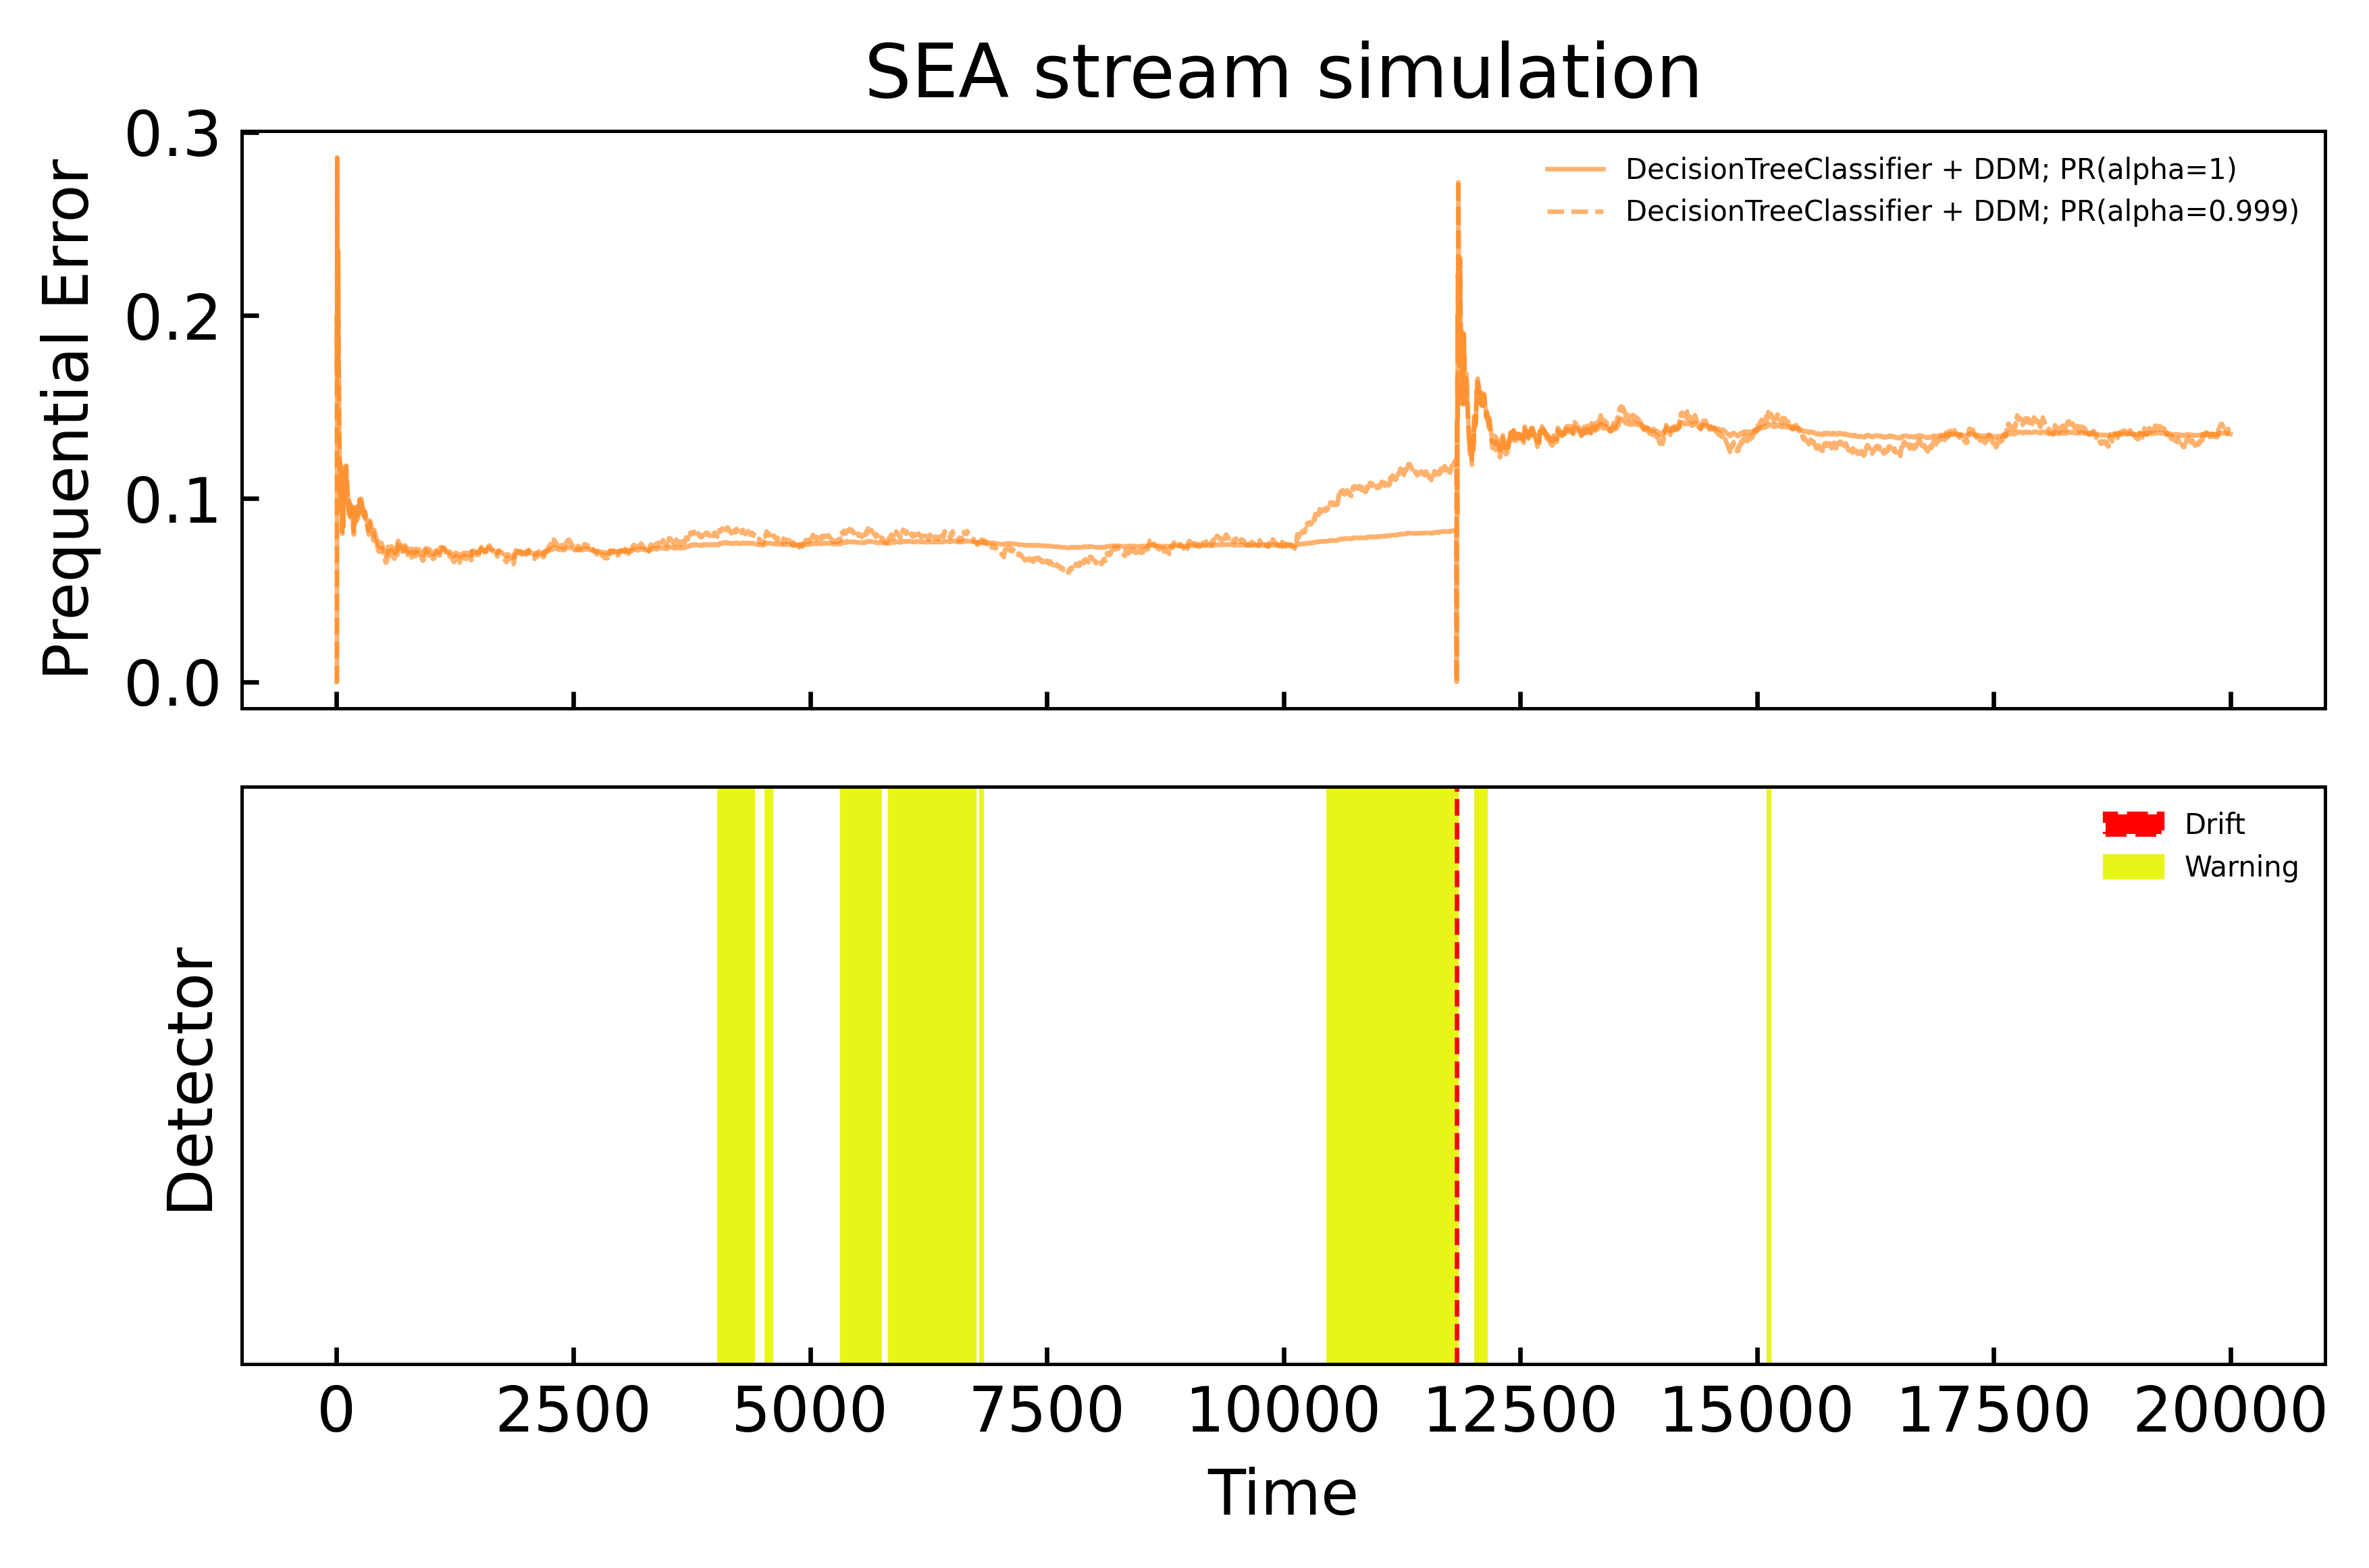

In [305]:
fsize = 11
tsize = 5
tdir = 'in'
major = 3.0
minor = 1.5
lwidth = 0.6
lhandle = 2.0

plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

lines = ["-", "--"]

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, dpi=600)

alpha = 0.6
linewidth = 0.8

for (metric_name, metric_values), line in zip(metrics_historic_detector.items(), lines):
    ax[0].plot(metric_values,
               color="#ff7f0e",
               linestyle=line,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=linewidth)

ax[0].title.set_text("Stream simulation")
ax[0].set_ylabel("Prequential Error")
ax[0].legend(frameon=False)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
ax[1].legend(handles=[drift_path, warning_path], frameon=False)
plt.xlabel("Time")
plt.tight_layout()
plt.show()

Taking into account that the detector has been previously trained on Concept/Block 1 of SEA {cite:p}`street2001streaming` generator, the results can be interpreted as follows:
1. [0 - 9999] (Concept 3): At the beginning the detector has seen only a few samples, so the error fluctuates quite a bit and the fact that the min_num_instances parameter has a value of 100 means that no drift can be detected at the beginning, although the detector statistics are updated from the first sample. Subsequently, the error decreases and starts to stabilize, so the detector will not detect drift. The detector goes through several warning zones over the 5000 sample, but none of them ends in drift. In this case, the detector is not capable of detect de change of concept from Concept 1 to Concept 3.
2. [10000 - 19999] (Concept 4): Through the use of the error metric with alpha=0.99, it is possible to visualize from the beginning of the new concept that the error is increasing, so the detector enters a warning zone. After a few samples, drift is detected at index 11824.  In this case, the detector is capable of detect the change of concept from Concept 1 to Concept 4. Since we are using NormalMode, it would be up to the user to decide what to do next, whether to leave the model running knowing that a concept change has occurred, or to retrain it.


```{bibliography}
:filter: docname in docnames
```